# Support vector machines solvers

The objective is to solve the **primal** problem:

$$
\begin{aligned}
\min_{w \in \mathbb{R}^n,\, z \in \mathbb{R}^m}  & \quad \frac{1}{2} ||w||_2^2 + C \mathbb{1}^T z \\
\text{subject to } & \quad y_i(w^T x_i) \geq 1-z_i, \quad i = 1,...,m \\
& \quad z \geq 0
\end{aligned}
$$

We define $f(w, z) = \frac{1}{2} ||w||_2^2 + C \mathbb{1}^T z$ the objective function and, for $i = 1,...,m$, $g_i(w, z) = 1-z_i-y_i(w^T x_i)$ and $h_i(w, z) = -z_i$ the inequality constraint functions.

We can rewrite the optimization problem using these functions:

$$
\begin{aligned}
\min_{w,\, z} & \quad f(w, z) \\
\text{subject to } & \quad g_i(w, z) \leq 0, \quad i = 1,...,m \\
& \quad h_i(w, z) \leq 0, \quad i = 1,...,m
\end{aligned}
$$

**Note :** A vector $p \in \mathbb{R}^k$ is represented by a one-column matrix with $k$ lines. For making notations easy to write, we represent the vertical concatenation of $p \in \mathbb{R}^k$ and $q \in \mathbb{R}^l$ by $[p \, |\, q]$.

## Primal and dual approximations via logarithmic barrier

### Primal approximation

We approximate the primal problem by this problem:

$$
\begin{aligned}
\min_{w,\, z} & \quad f(w, z) - \frac{1}{t}\left(\sum_{i = 1}^m \log(-g_i(w, z)) +  \sum_{i = 1}^m \log(-h_i(w, z))\right)
\end{aligned}
$$

To optimize it, we will need the following gradients:

- $\nabla f(w, z) = [w\,|\,C\mathbb{1}]$
- $\nabla g_i(w, z) = -[y_i x_i\,|\,\mathbb{1}_i]$ where $\mathbb{1}_i$ is the vector with a $1$ at position $i$ and zeros otherwise
- $\nabla h_i(w, z) = -[\mathbb{0}\,|\,\mathbb{1}_i]$

and the following hessians:

- $\nabla^2 f(w, z) = \left( \begin{array}{cc}
I_n & O \\
O & O \end{array} \right)$
- $\nabla^2 g_i(w, z) = O$
- $\nabla^2 h_i(w, z) = O$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_f_w_z(C, len_w):
    """
    The objective function
    p = (w, z)
    @type C: int
    """
    def f(p):
        return 1/2 * (np.linalg.norm(p[:len_w]))**2 + C * np.ones(p[len_w:, 0].shape).T.dot(p[len_w:, 0])
    return f

def get_g_i_w_z(i, x, y):
    """
    The inequality constaint on g
    p = (w, z)
    @param i: a integer beetween 1 and m
    @type i: int
    @param x: the vector x of the constraint, each value is in R
    @type x: int[m][n]
    @param y: the vector y of the constraint, each value is in (-1, 1)
    @type y: int[m]
    """
    def f(p):
        return 1 - p[x.shape[0]:, 0][i] - y[0, i] * p[:x.shape[0], 0].T.dot(x[:,i])
    return f

def get_h_i_w_z(i, len_w):
    """
    The inequality constraint on h
    p = (w, z)
    @param i: a integer beetween 1  and m
    @type i: int
    """
    def f(p):
        return - p[len_w:, 0][i]
    return f

def get_primal_fs(C, max_i, x, y):
    obj_fun = [get_f_w_z(C, x.shape[0])]
    ineq_const_g = [get_g_i_w_z(i, x, y) for i in range(max_i)]
    ineq_const_h = [get_h_i_w_z(i, x.shape[0]) for i in range(max_i)]
    return obj_fun + ineq_const_g + ineq_const_h

In [3]:
# Les gradients

def i_1_vector(i, size):
    """
    Create an array of size "size" with 0 everywhere except for the
    i-th cell where there is a one
    @param i: the cell where a 1 is wanted
    @type i: int
    @param size: the size of the wanted array
    @type size: int
    """
    return np.array([[0.] if k != i else [1.] for k in range(size)])

def get_grad_f_w_z(C, len_w):
    """
    The gradient of the objective function
    p = (w, z)
    @type C: int
    """
    def f(p):
        return np.concatenate((p[:len_w], C * np.ones(p[len_w:].shape)))
    return f

def get_grad_g_i_w_z(i, x, y):
    """
    The gradient of the inequality constraint g
    p = (w, z)
    @param i: a integer beetween 1 and m
    @type i: int
    @param x: the vector x of the constraint, each value is in R
    @type x: int[m][n]
    @param y: the vector y of the constraint, each value is in (-1, 1)
    @type y: int[m]
    """
    def f(p):
        return np.array(-np.concatenate((y[0, i] * x[:,i:i+1], i_1_vector(i, len(p[x.shape[0]:])))))
    return f

def get_grad_h_i_w_z(i, len_w):
    """
    The gradient of the inequality constraint h
    p = (w, z)
    @param i: a integer beetween 1  and m
    @type i: int
    """
    def f(p):
        return np.array(-np.concatenate((np.zeros(p[:len_w].shape), i_1_vector(i, len(p[len_w:])))))
    return f

def get_primal_fps(C, max_i, x, y):
    grad_obj_fun = [get_grad_f_w_z(C, x.shape[0])]
    grad_ineq_const_g = [get_grad_g_i_w_z(i, x, y) for i in range(max_i)]
    grad_ineq_const_h = [get_grad_h_i_w_z(i, x.shape[0]) for i in range(max_i)]
    return grad_obj_fun + grad_ineq_const_g + grad_ineq_const_h

In [4]:
# Les hessiennes

def get_hes_f_w_z(len_w):
    """
    The hessienne of the objective function
    """
    def f(p):
        return np.concatenate((
                        np.concatenate((np.identity(len(p[:len_w])), np.zeros((len(p[:len_w]), len(p[len_w:])))), axis = 1), \
                        np.zeros((len(p[len_w:]), len(p[:len_w]) + len(p[len_w:])))))
    return f

def get_hes_g_i_w_z():
    """
    The hessienne of the inequality constraint g
    """
    def f(p):
        return np.zeros((len(p), len(p)))
    return f

def get_hes_h_i_w_z():
    """
    The hessienne of the inequality constraint h
    """
    def f(p):
        return np.zeros((len(p), len(p)))
    return f

def get_primal_fpps(max_i, len_w):
    hes_obj_fun = [get_hes_f_w_z(len_w)]
    hes_ineq_const_g = [get_hes_g_i_w_z() for _ in range(max_i)]
    hes_ineq_const_h = [get_hes_h_i_w_z() for _ in range(max_i)]
    return hes_obj_fun + hes_ineq_const_g + hes_ineq_const_h

In [5]:
def get_fs_fps_fpps(C, max_i, x, y):
    return get_primal_fs(C, max_i, x, y), get_primal_fps(C, max_i, x, y), get_primal_fpps(max_i, x.shape[0])

### Dual approximation

Before approximating the dual, we need to find the **dual** problem. We define the laplacian:
$$L(w, z, u, v) = f(w, z) + \sum_{i = 1}^m u_i g_i(w, z) + \sum_{i = 1}^m v_i h_i(w, z).$$
As $\nabla^2_{w, z} L(w, z, u, v) = \left( \begin{array}{cc}
I_n & O \\
O & O \end{array} \right) \succcurlyeq 0$, $(w, z) \mapsto L(w, z, u, v)$ is convex. In order to minimize $L(w, z, u, v)$ in $w$ and $z$, we just need to find $w$ and $z$ such that:

- $\nabla_w L(w, z, u, v) = w - \sum_{i = 1}^{m} u_i y_i x_i = \mathbb{0}$
- $\nabla_z L(w, z, u, v) = C \mathbb{1} - u - v = \mathbb{0}$.

Then, we get the dual problem:

$$
\begin{aligned}
\max_{u \in \mathbb{R}^m}  & \quad - \frac{1}{2} ||Ku||_2^2 + \mathbb{1}^T u \\
\text{subject to } & \quad -u \leq 0 \\
& \quad u - C\mathbb{1}\leq 0
\end{aligned}
$$

where $K = \left( y_1 x_1 \,|\, ... \,|\, y_m x_m \right)$.

We define $r(u) = - \frac{1}{2} ||Ku||_2^2 + \mathbb{1}^T u$ the objective function and, for $i = 1,...,m$, $s_i(u) = -u_i$ and $t_i(u) = u_i-C$ the inequality constraint functions.

We approximate the dual problem by this problem:

$$
\begin{aligned}
\max_{u} & \quad r(u) - \frac{1}{t}\left(\sum_{i = 1}^m \log(-s_i(u)) +  \sum_{i = 1}^m \log(-t_i(u))\right)
\end{aligned}
$$

To optimize it, we will need the following gradients:

- $\nabla r(u) = - K^T K u + \mathbb{1}$
- $\nabla s_i(u) = -\mathbb{1}_i$
- $\nabla t_i(u) = \mathbb{1}_i$

and the following hessians:

- $\nabla^2 r(u) = - K^T K$
- $\nabla^2 s_i(u) = O$
- $\nabla^2 t_i(u) = O$

In [6]:
def K(x, y):
    return (x * y)

def get_r_x_y(x, y):
    k = K(x, y)
    def f(u):
        return -1/2 * np.linalg.norm(k.dot(u))**2 + np.sum(u)
    return f

def get_s_i(i):
    def f(u):
        return -u[i, 0]
    return f

def get_t_i(i, c):
    def f(u):
        return u[i, 0] - c
    return f

def get_dual_fs(c, max_i, x, y):
    obj_fun = [get_r_x_y(x, y)]
    ineq_const_s = [get_s_i(i) for i in range(max_i)]
    ineq_const_t = [get_t_i(i, c) for i in range(max_i)]
    return obj_fun + ineq_const_s + ineq_const_t

In [7]:
# Les gradients

def get_grad_r_x_y(x, y):
    k = np.array(K(x, y))
    def f(u):
        return - k.T.dot(k).dot(u) + np.ones(u.shape)
    return f

def get_grad_s_i(i):
    def f(u):
        return - i_1_vector(i, len(u))
    return f

def get_grad_t_i(i):
    def f(u):
        return i_1_vector(1, len(u))
    return f

def get_dual_fps(max_i, x, y):
    grad_obj_fun = [get_grad_r_x_y(x, y)]
    grad_ineq_const_s = [get_grad_s_i(i) for i in range(max_i)]
    grad_ineq_const_t = [get_grad_t_i(i) for i in range(max_i)]
    return grad_obj_fun + grad_ineq_const_s + grad_ineq_const_t

In [8]:
# Les hessiennes

def get_hes_r_x_y(x, y):
    k = np.array(K(x, y))
    def f(u):
        return - k.T.dot(k)
    return f

def get_hes_s():
    def f(u):
        return np.zeros((len(u), len(u)))
    return f

def get_hes_t():
    def f(u):
        return np.zeros((len(u), len(u)))
    return f

def get_dual_fpps(max_i, x, y):
    hes_obj_fun = [get_hes_r_x_y(x, y)]
    hes_ineq_const_s = [get_hes_s() for _ in range(max_i)]
    hes_ineq_const_t = [get_hes_t() for _ in range(max_i)]
    return hes_obj_fun + hes_ineq_const_s + hes_ineq_const_t

In [9]:
def get_dual_fs_fps_fpps(C, max_i, x, y):
    return get_dual_fs(C, max_i, x, y), get_dual_fps(max_i, x, y), get_dual_fpps(max_i, x, y)

## Primal and dual optimizations via logarithmic barrier

In [10]:
def logarithmic_barrier_approx(t, Fs, Fps, Fpps):
    """
    Computes the logarithmic barrier approximation function
    of a convex optimization problem, its gradient and its hessian
    (formulas in slide 74, course 2).
    
    Args:
        t: the approximation quality
        Fs: the list with the objective function first and the
            inequality constraint functions next
        Fps: the list with the gradients of the objective function first
             and the inequality constraint functions next
        Fpps: the list with the hessians of the objective function first
              and the inequality constraint functions next
    
    Returns:
        The logarithmic barrier approximation function, its gradient
        and its hessian.
    """
    def LF(x):
        r = t*Fs[0](x)
        for i in range(1, len(Fs)):
            r += (-np.log(-Fs[i](x)))
        return r
    
    def LFp(x):
        r = t*Fps[0](x)
        for i in range(1, len(Fs)):
            r += (-1/Fs[i](x)*Fps[i](x))
        return r
    
    def LFpp(x):
        r = t*Fpps[0](x)
        for i in range(1, len(Fs)):
            r += (1/Fs[i](x)**2*Fps[i](x).dot(Fps[i](x).T)-1/Fs[i](x)*Fpps[i](x))
        return r
    
    return LF, LFp, LFpp

In [11]:
# Backtracking line search parameters

alpha = 0.45
beta = 3/4

def newton(F, Fp, Fpp, x0, eps):
    """
    Minimizes F using Newton's method (algorithm in slide 20, course 2).
    
    Args:
        F: a function from R^n to R
        Fp: the gradient of F
        Fpp: the hessian of F
        x0: the initial point
        eps: the precision of the approximation
    
    Returns:
        The sequence of approximations of the extremum of F up to a
        precision eps. Useful for debugging.
    """
    def is_feasible(x):
        return not(np.isnan(F(x)))
    
    def get_next_x(x):
        Fpx = Fp(x)
        delta_x = -np.linalg.inv(Fpp(x)).dot(Fpx)
        # Backtracking line search
        t = 1
        prev_fx = F(x)
        while (F(x + t*delta_x) >= (F(x)+ alpha * t * Fpx.T.dot(delta_x))[0][0]  and F(x + t*delta_x) < prev_fx) or not(is_feasible(x + t*delta_x)):          
            if is_feasible(x + t*delta_x):
                prev_fx =  F(x + t*delta_x)
            t = beta*t
        return x + t*delta_x
        
    xs = [x0]
    λ = np.inf
    while λ / 2 > eps:
        λ = Fp(xs[-1]).T.dot(np.linalg.inv(Fpp(xs[-1]))).dot(Fp(xs[-1]))
        xs.append(get_next_x(xs[-1]))
    return xs

In [12]:
# Barrier method parameter
mu = 3

def barrier(Fs, Fps, Fpps, x0, eps):
    """
    Approximate the extremum of F using barrier method
    (algorithm in slide 80, course 2).
        Args:
        Fs: the list with the objective function first and the
            inequality constraint functions next
        Fps: the list with the gradients of the objective function first
             and the inequality constraint functions next
        Fpps: the list with the hessians of the objective function first
              and the inequality constraint functions next
        x0: the initial point
        eps: the precision of the approximation
    
    Returns:
        An approximation of the extremum of F.
    """
    def is_feasible(x):
        for f in Fs[1:]:
            if f(x) >= 0:
                return False
        return True
    
    if not(is_feasible(x0)):
        print("The initial point is not a feasible point")
        return None

    x = x0
    t = 1
    m = len(Fs) - 1
    
    while m/t >= eps:
        LF, LFp, LFpp = logarithmic_barrier_approx(t, Fs, Fps, Fpps)
        x = newton(LF, LFp, LFpp, x, eps)[-1]
        t = mu*t
    
    return x

## Test sur des points générés selon 2 gaussiennes

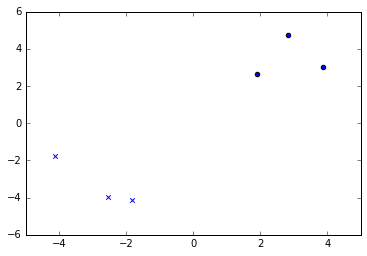

In [13]:
nb_point = 3

# on prepare les datasets
x_ok = np.random.multivariate_normal([-3, -3], [[1, 0], [0, 1]], size = nb_point).T
y_ok = np.array([[-1 for _ in range(nb_point)]])

x_ko = np.random.multivariate_normal([3, 3], [[1, 0], [0, 1]], size = nb_point).T
y_ko = np.array([[1 for _ in range(nb_point)]])

#x_ok = np.array([[1, 1]]).T
#y_ok = np.array([[1]])

#x_ko = np.array([[-100, -100]]).T
#y_ko = np.array([[-1]])

plt.scatter(x_ok[0, :], x_ok[1, :], marker = "x")
plt.scatter(x_ko[0, :], x_ko[1, :], marker = "o")
plt.show()

x = np.concatenate((x_ok, x_ko), axis=1) # cas ou pas d'ordo à l'origine
#x_init = np.concatenate((x_ok, x_ko), axis=1) # cas où on veut 1 pour ordo à l'origine
#x = np.concatenate((np.ones((1, x_init.shape[1])), x_init)) # cas où on veut 1 pour ordo à l'origine
y = np.concatenate((y_ok, y_ko), axis=1)

In [14]:
fs, fps, fpps = get_fs_fps_fpps(4, x.shape[1], x, y)
x_0 = np.ones((x.shape[0]+x.shape[1], 1))
#x_0[1] = 2
b = barrier(fs, fps, fpps, x_0, 0.1)

/home/joseph/.local/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in log


In [15]:
w = b[0:2].T[0] # cas ou pas d'ordo à l'origine
w_0 = 0 # cas ou pas d'ordo à l'origine
#w = b[1:3].T[0] # cas où on veut 1 pour ordo à l'origine
#w_0 = b[0][0] # cas où on veut 1 pour ordo à l'origine

def predict(x):
    if w.dot(x) + w_0 < 0:
        return -1
    return 1

In [16]:
#x_print = x.T[:, 1:3] # cas où on veut 1 pour ordo à l'origine
x_print = x.T # cas ou pas d'ordo à l'origine

In [33]:
import warnings
warnings.filterwarnings('ignore')
def plot_frontiere_LDA_CDA(set, predict, step=100):
    mmax= np.max(set[:,0]) + 1, np.max(set[:, 1]) + 1
    mmin= np.min(set[:,0]) - 1, np.min(set[:, 1]) - 1
    
    #print(mmax)
    #print(mmin)
    mmax = max(mmax), max(mmax)
    mmin = min(mmin), min(mmin)
    mmin
    x1grid,x2grid=np.meshgrid(np.linspace(mmin[0],mmax[0],step),np.linspace(mmin[1],mmax[1],step))
    grid=np.hstack((x1grid.reshape(x1grid.size,1),x2grid.reshape(x2grid.size,1)))
    
    # calcul de la prediction pour chaque point de la grille
    res=np.array([predict(grid[i,:]) for i in range(len(grid)) ])
    res=res.reshape(x1grid.shape)
    # tracer des frontieres
    plt.contourf(x1grid,x2grid,res,colors=["cyan","red"],levels=[-1, 0, 1],linewidth=2)

In [18]:
#w_0 -= w.dot((x_ok + x_ko)/2)[0] #-> ce dont on a besoin pour que ça soit bien centré quand on a deux points et qu'on voudrait avoir avec l'ordo à l'origine (dans le cas de deux points ici)

In [34]:
plt.figure(figsize=(10,10))

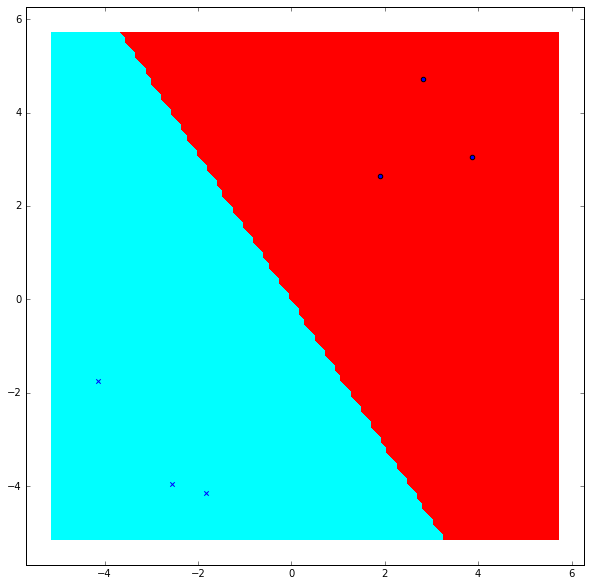

In [35]:
plot_frontiere_LDA_CDA(x_print, predict)
plt.scatter(x_ok[0, :], x_ok[1, :], marker = "x")
plt.scatter(x_ko[0, :], x_ko[1, :], marker = "o")

#plt.scatter([-1, 1], [1, -1])
plt.show()

In [21]:
fs, fps, fpps = get_dual_fs_fps_fpps(2.0, x.shape[1], x, y)
u = np.ones((x.shape[1], 1))
b = barrier(fs, fps, fpps, u, 0.0001)

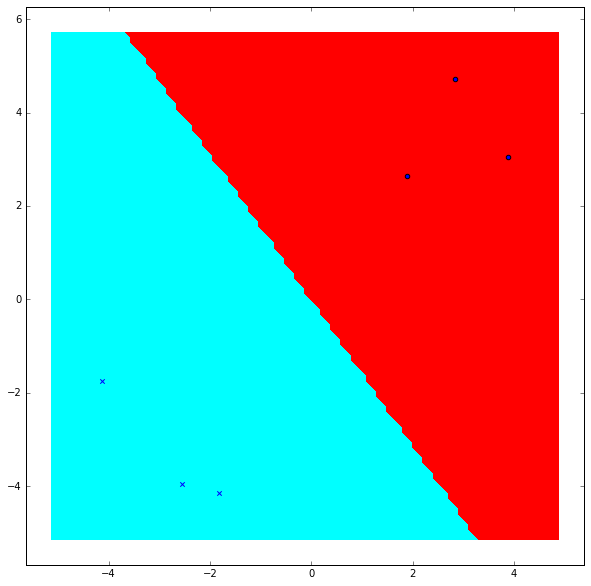

In [22]:
w = b[0:2].T[0] # cas ou pas d'ordo à l'origine
w_0 = 0 # cas ou pas d'ordo à l'origine
#w = b[1:3].T[0] # cas où on veut 1 pour ordo à l'origine
#w_0 = b[0][0] # cas où on veut 1 pour ordo à l'origine

def predict(x):
    if w.dot(x) + w_0 < 0:
        return -1
    return 1

#x_print = x.T[:, 1:3] # cas où on veut 1 pour ordo à l'origine
x_print = x.T # cas ou pas d'ordo à l'origine

plt.figure(figsize=(10,10))

plot_frontiere_LDA_CDA(x_print, predict)
plt.scatter(x_ok[0, :], x_ok[1, :], marker = "x")
plt.scatter(x_ko[0, :], x_ko[1, :], marker = "o")

#plt.scatter([-1, 1], [1, -1])
plt.show()